## IMDB analysis with scikit-learn & custom algorithms
### Naive Bayes Classifier

Ορίζουμε τις υπερπαραμέτρους που απαιτούνται για τα δεδομένα που θα χρησιμοποιήσουμε παρακάτω.

In [1]:
m = 3000   # Number of words in the vocabulary
n = 50    # N most frequent words to skip
k = 50      # K least frequent words to skip

infogain = False
g = 800 

Παίρνουμε τα δεδομένα από τη βάση δεδομένων του IMDB, αγνοώντας τις πιο συχνά χρησιμοποιούμενες λέξεις n και τις λιγότερες χρησιμοποιούμενες λέξεις k. 

(Είναι οι υπερπαράμετροι που ορίσαμε παραπάνω.)

In [2]:
import tensorflow as tf
import numpy as np
from math import log 

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.imdb.load_data(num_words=m-k, skip_top=n)
word_index = tf.keras.datasets.imdb.get_word_index()

index2word = dict((i + 3, word) for (word, i) in word_index.items())
index2word[0] = '[pad]'
index2word[1] = '[bos]'
index2word[2] = '[oov]'

x_train = np.array([' '.join([index2word[idx] for idx in text]) for text in x_train])
x_test = np.array([' '.join([index2word[idx] for idx in text]) for text in x_test])

### Binary Vector Creation
Τροποποιούμε τα δεδομένα που πήραμε έτσι ώστε να γίνουν δυαδικά διανύσματα. Τα διανύσματα αυτά αποτελούνται απο 0 και 1, με 1 να σημαίνει ότι η λέξη υπάρχει στο κείμενο, ενώ με 0 δεν υπάρχει.

In [3]:
from sklearn.feature_extraction.text import CountVectorizer

binary_vectorizer = CountVectorizer(binary=True)
x_train_binary = binary_vectorizer.fit_transform(x_train)
x_test_binary = binary_vectorizer.transform(x_test)

x_train_binary = np.array(x_train_binary.toarray())
x_test_binary = np.array(x_test_binary.toarray())
print(
    'Vocabulary size:', len(binary_vectorizer.vocabulary_)
)

Vocabulary size: 2843


Χ είναι ένας πίνακας διανυσμάτων (αξιολογήσεων), με κάθε διάνυσμα να αναπαριστά λέξεις. 
Y είναι ένα διάνυσμα με ετικέτες (0 ή 1) όπου 0 είναι μια αρνητική αξιολόγηση και 1 μια θετική.

$$X = \begin{bmatrix} \vec{x_{1}} \\ \vdots \\ \vec{x_{m}} \end{bmatrix}\, \, \, 
y = \begin{bmatrix} y_{1} \\ \vdots \\ y_{m} \end{bmatrix}$$

### Κέρδος Πληροφορίας
Είναι κώδικας από τα εργαστήρια. Επιστρέφει τις g λέξεις με το μεγαλύτερο κέρδος πληροφορίας από το σύνολο δεδομένων.

In [4]:
from math import log 

if infogain:
  def IG(class_, feature):
    classes = set(class_)

    Hc = 0
    for c in classes:
      pc = list(class_).count(c)/len(class_)
      Hc += - pc * log(pc, 2)
    feature_values = set(feature)

    Hc_feature = 0 # Αρχικοποίηση της εντροπίας του χαρακτηριστικού Hc_feature.
    for feat in feature_values:
      
      # Υπολογισμός του P(X=x)
      pf = list(feature).count(feat)/len(feature)
      indices = [i for i in range(len(feature)) if feature[i] == feat]
      clasess_of_feat = [class_[i] for i in indices]
      for c in classes:
          # Υπολογισμός του P(C=c|X=x)
          pcf = clasess_of_feat.count(c)/len(clasess_of_feat)
          if pcf != 0: 
              # Υπολογισμός του - P(X=x) * P(C=c|X=x) * log2(P(C=c|X=x))
              temp_H = - pf * pcf * log(pcf, 2)
              #sum for all values of C (class) and X (values of specific feature)
              Hc_feature += temp_H
    # Υπολογισμός του information gain.
    ig = Hc - Hc_feature
    return ig

  # Επιλογή των g πιο σημαντικών χαρακτηριστικών.
  ig = [(i, IG(y_train, x_train_binary[:, i])) for i in range(len(x_train_binary[0]))]
  ig.sort(key=lambda x: x[1], reverse=True)
  ig = ig[:g]
  # Προσαρμογή των δεδομένων εκπαίδευσης και ελέγχου.
  x_train_binary = x_train_binary[:, [i[0] for i in ig]]
  x_test_binary = x_test_binary[:, [i[0] for i in ig]]

## Bernoulli Naive Bayes Classifier Implementation
Κλάση που υλοποιεί τον Bernoulli Naive Bayes Classifier. Η κλαση έχει δύο μεθόδους train και predict. Η μέθοδος train εκπαιδεύει τον αλγόριθμο χρησιμόποιώντας ένα πίνακα διανυσμάτων x που δίνεται. Η μέθοδος predict δέχεται ένα πίνακα διανυσμάτων και επιστρέφει ένα διάνυσμα με ετικέτες.

Χρησιμοποιούμε και εκτιμήτρια Laplace για την εξομάλυνση πιθανοτήτων και την αποφυγή μηδενικών εκτιμήσεων.

In [5]:
class BernoulliNaiveBayes:
  
  def __init__(self):
    pass 

  def fit(self, x, y):
    all_positive = np.sum(y)
    all_texts = len(y)

    # Υπολογισμός της (log) πιθανότητας για κάθε κλάση
    self.positive = np.log(all_positive / all_texts)
    self.negative = np.log(1 - all_positive / len(y))
    
    # Υπολογισμός (log) πιθανότητας για κάθε σύνολο χαρακτηριστικών δεδομένα κάθε κλάσης (y = 1 ή y = 0)
    # p(feature|class) = (np.sum(X[y == class], axis=0) + 1) / (np.sum(y) + 2)
    self.positive_1 = np.log((np.sum(x[y == 1], axis=0) + 1) / (all_positive + 2))
    self.negative_1 = np.log((np.sum(x[y == 0], axis=0) + 1) / (all_texts - all_positive + 2))
    self.positive_0 = np.log(1.0 - (np.sum(x[y == 1], axis=0) + 1) / (all_positive + 2))
    self.negative_0 = np.log(1.0 - (np.sum(x[y == 0], axis=0) + 1) / (all_texts - all_positive + 2))
    
    
  def predict(self, x):

    x_reverse = np.where((x==0)|(x==1), x^1, x)
    # Υπολογισμός των (log) πιθανοτήτων για κάθε κλάση
    positive = x_reverse.dot(self.positive_0) + x.dot(self.positive_1) + self.positive
    negative = x_reverse.dot(self.negative_0) + x.dot(self.negative_1) + self.negative
    # Καθορισμός της πρόβλεψης βάσει των (log) πιθανοτήτων
    return np.array([1 if positive[i] > negative[i] else 0 for i in range(len(x))])

[0.88608, 0.872, 0.86848, 0.8648, 0.861248, 0.8600533333333333, 0.8590171428571428, 0.8582]


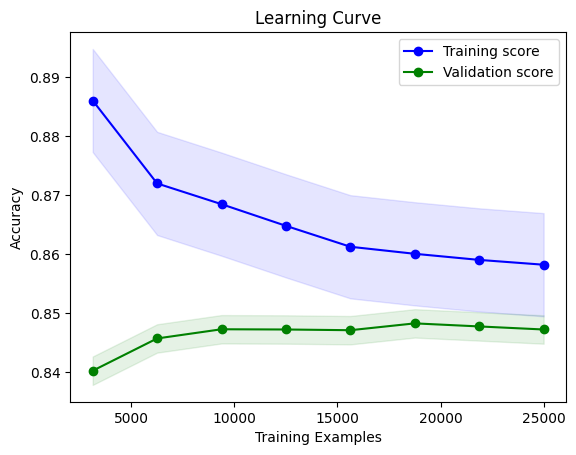

In [48]:

def plot_learning_curve(data, title="Learning Curve", full_scale=False):

    split_size = data['split_size']
    split = data['splits']
    splits = list(range(split_size, split*split_size + split_size, split_size))
    train_acc = data['train_accuracy']
    test_acc = data['test_accuracy']

    print(train_acc)
    train_scores_mean = np.mean(train_acc)
    train_scores_std = np.std(train_acc)
    val_scores_mean = np.mean(test_acc)
    val_scores_std = np.std(test_acc)

    if full_scale:
        plt.ylim(0, 1)
    plt.title(title)
    plt.xlabel("Training Examples")
    plt.ylabel("Accuracy")
    plt.plot()

    plt.fill_between(splits, train_acc - train_scores_std,
                     train_acc + train_scores_std, alpha=0.1,
                     color="b")
    plt.fill_between(splits, test_acc - val_scores_std,
                     test_acc + val_scores_std, alpha=0.1,
                     color="green")
    plt.plot(splits, train_acc, 'o-', color="b",
             label="Training score")
    plt.plot(splits, test_acc, 'o-', color="green",
             label="Validation score")

    plt.legend(loc="best")
    plt.show()


dataa = classification_data(BernoulliNaiveBayes(), x_train_binary, y_train, x_test_binary, y_test, 8)
plot_learning_curve(dataa)


In [6]:
from visualizations import *

## Bernoulli Naive Bayes Classifier Results and Comparison

Ο Naive Bayes Classifier εξετάζεται στα test δεδομένα και τα αποτελέσματα φαίνονται στον πίνακα παρακάτω. Επίσης γίνεται και μια σύγκριση μεταξύ των αποτελεσμάτων πρόβλεψης των δεδομένων εκπαίδευσης και των δεδομένων προς εξέταση. 

              precision    recall  f1-score   support

           0       0.85      0.85      0.85     12500
           1       0.85      0.85      0.85     12500

    accuracy                           0.85     25000
   macro avg       0.85      0.85      0.85     25000
weighted avg       0.85      0.85      0.85     25000



,Train Accuracy,Test Accuracy,Precision Train,Precision Test,Recall Train,Recall Test,F1 Train,F1 Test
5000,0.87,0.84,0.88,0.85,0.87,0.83,0.88,0.84
10000,0.87,0.85,0.86,0.85,0.87,0.85,0.87,0.85
15000,0.86,0.85,0.86,0.85,0.87,0.84,0.86,0.85
20000,0.86,0.85,0.86,0.85,0.86,0.84,0.86,0.85
25000,0.86,0.85,0.85,0.85,0.87,0.85,0.86,0.85


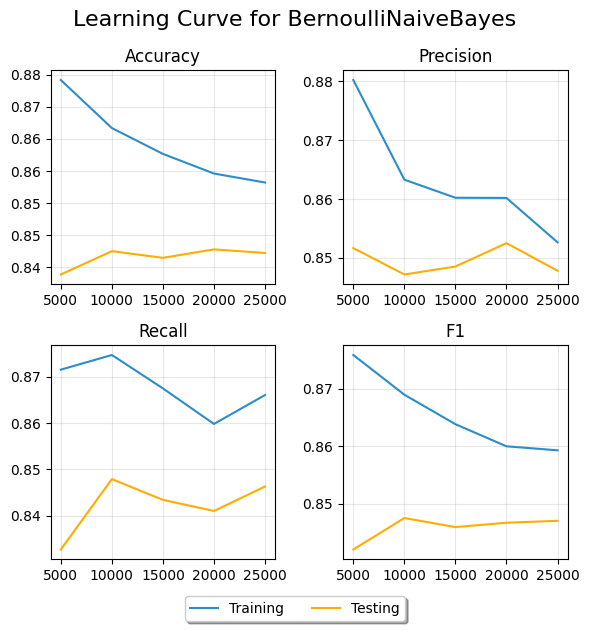

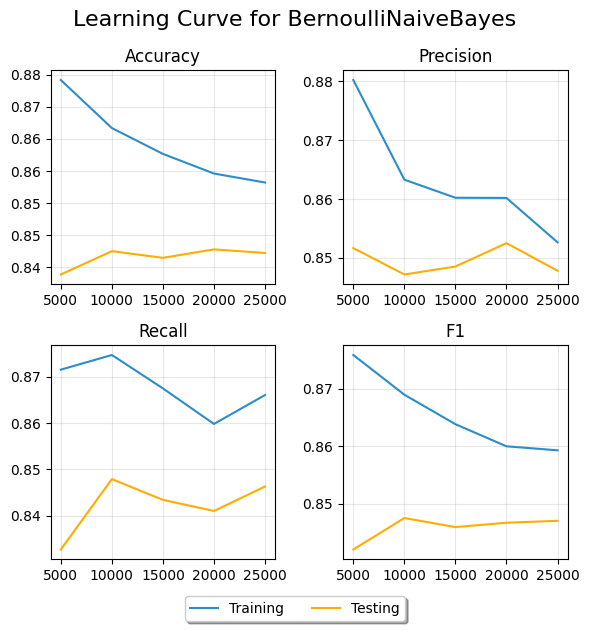

In [14]:
data = classification_data(BernoulliNaiveBayes(), x_train_binary, y_train, x_test_binary, y_test, 5)

print(classification_report(y_test, data['test_predictions']))
data_table = classification_table(data, x_train_binary)
ipd.display(data_table)
classification_plots(data)

## Bernoulli Naive Bayes against SKLearn's Bernoulli Naive Bayes

Ο Bernoulli Naive Bayes εξετάζεται ενάντια στον Bernoulli Naive Bayes της βιβλιοθήκης SKLearn. Τα αποτελέσματα φαίνονται παρακάτω στον πίνακα και όπως περιμέναμε είναι όμοια. (Παρακάτω φαίνεται η διαφορά μεταξύ των αποτελεσμάτων που έδωσε κάθε αλγόριθμος)

In [14]:
from sklearn.naive_bayes import BernoulliNB

bayes_data = classification_data(BernoulliNB(), x_train_binary, y_train, x_test_binary, y_test, 5)
bayes_data['estimator'] = 'SKBernoulliNB'
bayes_table = classification_table(bayes_data, x_train_binary)
difference_table = abs(bayes_table - data_table)
difference_table = difference_table.style.set_caption('Classification Table Difference for {estimator} against {estimator_2}'.format(estimator=data['estimator'], estimator_2=bayes_data['estimator']))
ipd.display(difference_table)

,Train Accuracy,Test Accuracy,Precision Train,Precision Test,Recall Train,Recall Test,F1 Train,F1 Test
5000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
10000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
15000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
20000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [49]:

N = [50, 100, 200, 300]
K = [0, 20, 50, 80]
M = [500, 2000, 2500, 3000]

binary_vectorizer = CountVectorizer(binary=True)
minK = 0
minN = 0
minM = 0
maxAccuracy = -float('inf')

for m in M:
    for n in N:
        for k in K:
            (x_trainn, y_trainn), (x_testt, y_testt) = tf.keras.datasets.imdb.load_data(num_words=m-k, skip_top=n)
            word_index = tf.keras.datasets.imdb.get_word_index()

            index2word = dict((i + 3, word) for (word, i) in word_index.items())
            index2word[0] = '[pad]'
            index2word[1] = '[bos]'
            index2word[2] = '[oov]'

            x_trainn = np.array([' '.join([index2word[idx] for idx in text]) for text in x_trainn])
            x_testt = np.array([' '.join([index2word[idx] for idx in text]) for text in x_testt])

            x_trainn_binary = binary_vectorizer.fit_transform(x_trainn)
            x_testt_binary = binary_vectorizer.transform(x_testt)

            x_trainn_binary = np.array(x_trainn_binary.toarray())
            x_testt_binary = np.array(x_testt_binary.toarray())

            bnb = BernoulliNaiveBayes()
            bnb. fit(x_trainn_binary, y_trainn)
            predicted_values = bnb.predict(x_testt_binary)
            print("For M={}, N={} and K={}:".format(m, n, k))
            acc = accuracy_score(y_testt, predicted_values)
            print('Accuracy:', acc)
            if acc > maxAccuracy:
                maxAccuracy = acc
                minN = n
                minK = k
                minM = m

print("\nBest model parameters are:\n\tN: {}\n\tK:{} \n\tM: {}".format(minN, minK, minM))



For M=500, N=50 and K=0:
Accuracy: 0.79724
For M=500, N=50 and K=20:
Accuracy: 0.79444
For M=500, N=50 and K=50:
Accuracy: 0.79236
For M=500, N=50 and K=80:
Accuracy: 0.78396
For M=500, N=100 and K=0:
Accuracy: 0.79332
For M=500, N=100 and K=20:
Accuracy: 0.79032
For M=500, N=100 and K=50:
Accuracy: 0.78688
For M=500, N=100 and K=80:
Accuracy: 0.7782
For M=500, N=200 and K=0:
Accuracy: 0.78556
For M=500, N=200 and K=20:
Accuracy: 0.78196
For M=500, N=200 and K=50:
Accuracy: 0.77652
For M=500, N=200 and K=80:
Accuracy: 0.76088
For M=500, N=300 and K=0:
Accuracy: 0.75152
For M=500, N=300 and K=20:
Accuracy: 0.74728
For M=500, N=300 and K=50:
Accuracy: 0.741
For M=500, N=300 and K=80:
Accuracy: 0.70912
For M=2000, N=50 and K=0:
Accuracy: 0.84204
For M=2000, N=50 and K=20:
Accuracy: 0.84192
For M=2000, N=50 and K=50:
Accuracy: 0.84204
For M=2000, N=50 and K=80:
Accuracy: 0.842
For M=2000, N=100 and K=0:
Accuracy: 0.83952
For M=2000, N=100 and K=20:
Accuracy: 0.83892
For M=2000, N=100 and K